In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import pyproj
import geopandas as gpd

from renewable_data_load import *
from climakitae.util.utils import clip_to_shapefile

In [2]:
def load_drought_mask(resource, module, domain, variable, simulation, gwl, data_dir="../../data/drought_masks"):
    """
    Load a drought mask from zarr store.
    
    Parameters
    ----------
    resource : str
        Resource type ('pv' or 'windpower')
    module : str
        Module type ('utility', 'distributed', 'onshore', 'offshore')
    domain : str
        Domain ('d02' or 'd03')
    variable : str
        Variable ('cf' or 'gen')
    simulation : str
        Climate model simulation name
    gwl : float
        Global warming level (0.8, 1.5, 2.0, 3.0, etc.)
    data_dir : str or Path
        Directory containing drought mask files
        
    Returns
    -------
    xr.DataArray
        Drought mask (1 = drought, 0 = no drought)
    """
    mask_file = f"{resource}_{module}_{domain}_{variable}_{simulation}_gwl{gwl}_drought_mask_only.zarr"
    mask_path = Path(data_dir) / mask_file
    
    if not mask_path.exists():
        raise FileNotFoundError(f"Drought mask not found: {mask_path}")
    
    # Open zarr store with consolidated metadata
    ds = xr.open_zarr(mask_path, consolidated=True)
    
    return ds['drought_mask']

In [3]:

simulations = ["mpi-esm1-2-hr", "miroc6", "taiesm1", "ec-earth3"]
domain = 'd02'
target_gwls = [0.8, 2.0]
variable = 'cf'
resource = 'pv'
module = 'utility'
data_dir = Path("../../data/drought_masks")

In [4]:
ls ../../data/drought_masks

pv_utility_d02_cf_ec-earth3_gwl0.8_drought_mask_only.nc
pv_utility_d02_cf_ec-earth3_gwl0.8_drought_mask_only.zarr/
pv_utility_d02_cf_ec-earth3_gwl2.0_drought_mask_only.nc
pv_utility_d02_cf_ec-earth3_gwl2.0_drought_mask_only.zarr/
pv_utility_d02_cf_miroc6_gwl0.8_drought_mask_only.nc
pv_utility_d02_cf_miroc6_gwl0.8_drought_mask_only.zarr/
pv_utility_d02_cf_miroc6_gwl2.0_drought_mask_only.nc
pv_utility_d02_cf_miroc6_gwl2.0_drought_mask_only.zarr/
pv_utility_d02_cf_mpi-esm1-2-hr_gwl0.8_drought_mask_only.nc
pv_utility_d02_cf_mpi-esm1-2-hr_gwl0.8_drought_mask_only.zarr/
pv_utility_d02_cf_mpi-esm1-2-hr_gwl2.0_drought_mask_only.nc
pv_utility_d02_cf_mpi-esm1-2-hr_gwl2.0_drought_mask_only.zarr/
pv_utility_d02_cf_taiesm1_gwl0.8_drought_mask_only.nc
pv_utility_d02_cf_taiesm1_gwl0.8_drought_mask_only.zarr/
pv_utility_d02_cf_taiesm1_gwl2.0_drought_mask_only.nc
pv_utility_d02_cf_taiesm1_gwl2.0_drought_mask_only.zarr/
windpower_offshore_d03_cf_ec-earth3_gwl0.8_drought_mask_only.zarr/
windpower_offshor

In [5]:
drought_masks = []
for target_gwl in target_gwls:
    drought_masks_gwl = []

    for simulation in simulations:

        # Load drought masks for solar and wind
        print(f"Loading drought masks for {simulation} at GWL {target_gwl}°C...")

        drought_mask = load_drought_mask(
            resource="pv",
            module="utility",
            domain=domain,
            variable=variable,
            simulation=simulation,
            gwl=target_gwl,
            data_dir=data_dir
        )

        drought_mask['simulation'] = simulation
        drought_mask['target_gwl'] = target_gwl

        drought_masks_gwl.append(drought_mask)
    drought_masks.append(xr.concat(drought_masks_gwl, dim='simulation', join='outer'))
all_drought_mask = xr.concat(drought_masks, dim='target_gwl', join='outer')



Loading drought masks for mpi-esm1-2-hr at GWL 0.8°C...
Loading drought masks for miroc6 at GWL 0.8°C...
Loading drought masks for taiesm1 at GWL 0.8°C...
Loading drought masks for ec-earth3 at GWL 0.8°C...
Loading drought masks for mpi-esm1-2-hr at GWL 2.0°C...
Loading drought masks for miroc6 at GWL 2.0°C...
Loading drought masks for taiesm1 at GWL 2.0°C...
Loading drought masks for ec-earth3 at GWL 2.0°C...


In [6]:
all_drought_mask

<xarray.DataArray 'drought_mask' (target_gwl: 2, simulation: 4, y: 320, x: 250,
                                  time: 29930)> Size: 153GB
dask.array<concatenate, shape=(2, 4, 320, 250, 29930), dtype=float64, chunksize=(1, 1, 20, 32, 1528), chunktype=numpy.ndarray>
Coordinates:
  * target_gwl         (target_gwl) float64 16B 0.8 2.0
  * simulation         (simulation) <U13 208B 'mpi-esm1-2-hr' ... 'ec-earth3'
  * y                  (y) float64 3kB -2.441e+05 -2.351e+05 ... 2.627e+06
  * x                  (x) float64 2kB -4.638e+06 -4.629e+06 ... -2.397e+06
  * time               (time) object 239kB 1981-01-01 00:00:00 ... 2062-12-31...
    dayofyear          (target_gwl, simulation, time) float64 2MB 1.0 ... nan
    Lambert_Conformal  int32 4B 1
    landmask           (y, x) float32 320kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 320kB 23.35 23.39 23.43 ... 56.42 56.46
    lon                (y, x) float32 320kB -116.5 -116.4 ... -111.6 -111.5
    quantile           float64 8B 0.1
    year               (target_gwl, simulation, time) float64 2MB 1.981e+03 ....
Attributes:
    resource:       pv
    module:         utility
    domain:         d02
    variable:       cf
    simulation:     mpi-esm1-2-hr
    reference_gwl:  0.8
    description:    Binary drought mask: 1 = drought (below threshold), 0 = n...

## Spatial Correlation Analysis

Goal: Identify which geographic areas tend to experience drought on the same days.

Approach:
1. Select test locations (or load facility locations)
2. Extract drought time series at each location
3. Calculate pairwise Pearson correlations between locations
4. Visualize correlation patterns

In [7]:
def generate_test_locations(drought_mask, n_locations=20, seed=42):
    """
    Generate test locations spread across the domain, snapping to nearest valid (non-NaN) grid cells.
    
    Parameters
    ----------
    drought_mask : xr.DataArray
        Drought mask to get domain dimensions from
    n_locations : int
        Number of test locations to generate
    seed : int
        Random seed for reproducibility
        
    Returns
    -------
    pd.DataFrame
        DataFrame with columns: location_id, x_idx, y_idx, x, y, is_valid, distance_to_valid
    """
    np.random.seed(seed)
    
    # Get domain dimensions
    x_size = len(drought_mask.x)
    y_size = len(drought_mask.y)
    
    # Generate random indices, avoiding edges
    x_indices = np.random.randint(5, x_size-5, n_locations)
    y_indices = np.random.randint(5, y_size-5, n_locations)
    
    # Check which locations are valid (have data at first timestep)
    # If valid at one timestep, should be valid for all timesteps
    sample_data = drought_mask.isel(time=0).values
    
    # For each location, find nearest valid grid cell if needed
    final_x_indices = []
    final_y_indices = []
    distances_moved = []
    
    for x_idx, y_idx in zip(x_indices, y_indices):
        # Check if location is valid (not NaN)
        if not np.isnan(sample_data[y_idx, x_idx]):
            # Location is valid, use as-is
            final_x_indices.append(x_idx)
            final_y_indices.append(y_idx)
            distances_moved.append(0.0)
        else:
            # Find nearest valid grid cell
            x_new, y_new, dist = find_nearest_valid_cell(sample_data, x_idx, y_idx)
            final_x_indices.append(x_new)
            final_y_indices.append(y_new)
            distances_moved.append(dist)
    
    # Get actual coordinate values
    x_coords = [drought_mask.x.values[i] for i in final_x_indices]
    y_coords = [drought_mask.y.values[i] for i in final_y_indices]
    
    locations_df = pd.DataFrame({
        'location_id': [f'loc_{i:02d}' for i in range(n_locations)],
        'x_idx': final_x_indices,
        'y_idx': final_y_indices,
        'x': x_coords,
        'y': y_coords,
        'distance_to_valid': distances_moved
    })
    
    return locations_df


def find_nearest_valid_cell(data_array, x_idx, y_idx, max_search_radius=50):
    """
    Find the nearest non-NaN grid cell to the target indices.
    
    Parameters
    ----------
    data_array : np.ndarray
        2D array with NaN values where data is invalid
    x_idx : int
        Target x index
    y_idx : int
        Target y index
    max_search_radius : int
        Maximum distance to search for valid cell
        
    Returns
    -------
    x_new : int
        X index of nearest valid grid cell
    y_new : int
        Y index of nearest valid grid cell
    distance : float
        Distance (in grid cells) to the nearest valid cell
    """
    # Create a valid mask (True where data is not NaN)
    valid_mask = ~np.isnan(data_array)
    
    # Create coordinate grids
    y_size, x_size = data_array.shape
    y_grid, x_grid = np.mgrid[0:y_size, 0:x_size]
    
    # Calculate distance to all grid cells
    distances = np.sqrt((x_grid - x_idx)**2 + (y_grid - y_idx)**2)
    
    # Mask out invalid cells (set their distance to infinity)
    distances_masked = np.where(valid_mask, distances, np.inf)
    
    # Find the indices of the minimum distance
    min_idx = np.unravel_index(np.argmin(distances_masked), distances_masked.shape)
    y_new, x_new = min_idx
    min_distance = distances_masked[min_idx]
    
    if min_distance > max_search_radius:
        raise ValueError(f"No valid grid cell found within {max_search_radius} cells of ({x_idx}, {y_idx})")
    
    return x_new, y_new, min_distance


def load_facility_locations(facility_file):
    """
    Load facility locations from file (to be implemented later).
    
    Parameters
    ----------
    facility_file : str or Path
        Path to facility locations file
        
    Returns
    -------
    pd.DataFrame
        DataFrame with columns: location_id, x_idx, y_idx, x, y
    """
    # Placeholder for future implementation
    # Expected format: CSV or shapefile with lat/lon or x/y coordinates
    # Will need to convert to grid indices
    raise NotImplementedError("Facility location loading not yet implemented")
    
    
def extract_location_time_series(drought_mask, locations_df):
    """
    Extract drought time series at specified locations.
    
    Parameters
    ----------
    drought_mask : xr.DataArray
        Drought mask with dimensions (time, y, x)
    locations_df : pd.DataFrame
        Locations with x_idx and y_idx columns
        
    Returns
    -------
    pd.DataFrame
        Wide-format DataFrame with time index and location_id columns
    """
    time_series_dict = {}
    
    for _, row in locations_df.iterrows():
        loc_id = row['location_id']
        x_idx = row['x_idx']
        y_idx = row['y_idx']
        
        # Extract time series at this location
        ts = drought_mask.isel(x=x_idx, y=y_idx).values
        time_series_dict[loc_id] = ts
    
    # Create DataFrame with time index
    df = pd.DataFrame(time_series_dict, index=drought_mask.time.values)
    
    return df

In [8]:
def calculate_spatial_correlations(time_series_df, min_variance=1e-6):
    """
    Calculate pairwise spatial association metrics for binary drought data.
    
    Computes three metrics:
    1. Pearson correlation (phi coefficient for binary data)
    2. Co-occurrence probability: P(both drought) / [P(A drought) × P(B drought)]
       - Values > 1 indicate droughts occur together more than expected by chance
    3. Jaccard similarity: (days both in drought) / (days at least one in drought)
       - Range 0-1, measures overlap of drought periods
    
    Filters out locations with insufficient variance (e.g., always/never in drought).
    
    Parameters
    ----------
    time_series_df : pd.DataFrame
        Time series data with locations as columns (binary 0/1 values)
    min_variance : float
        Minimum variance threshold to include a location
        
    Returns
    -------
    dict
        Dictionary containing:
        - 'pearson': Pearson correlation matrix (pd.DataFrame)
        - 'co_occurrence': Co-occurrence probability matrix (pd.DataFrame)
        - 'jaccard': Jaccard similarity matrix (pd.DataFrame)
        - 'info': Info dict about filtered locations
    """
    # Calculate variance for each location (excluding NaN)
    variances = time_series_df.var()
    
    # Filter out low-variance locations
    valid_locations = variances[variances > min_variance].index
    filtered_df = time_series_df[valid_locations]
    
    n_locs = len(valid_locations)
    locations = valid_locations.tolist()
    
    # Calculate Pearson correlation
    pearson_matrix = filtered_df.corr(method='pearson')
    
    # Calculate co-occurrence probability and Jaccard similarity
    co_occur_matrix = pd.DataFrame(np.zeros((n_locs, n_locs)), 
                                   index=locations, columns=locations)
    jaccard_matrix = pd.DataFrame(np.zeros((n_locs, n_locs)), 
                                  index=locations, columns=locations)
    
    for i, loc_a in enumerate(locations):
        for j, loc_b in enumerate(locations):
            if i == j:
                # Diagonal: perfect correlation/similarity with self
                co_occur_matrix.iloc[i, j] = 1.0
                jaccard_matrix.iloc[i, j] = 1.0
            else:
                # Get binary time series (drop NaN values)
                ts_a = filtered_df[loc_a].dropna().values
                ts_b = filtered_df[loc_b].dropna().values
                
                # Ensure same length (in case of different NaN patterns)
                if len(ts_a) != len(ts_b):
                    min_len = min(len(ts_a), len(ts_b))
                    ts_a = ts_a[:min_len]
                    ts_b = ts_b[:min_len]
                
                # Calculate probabilities
                p_a = ts_a.mean()  # P(A in drought)
                p_b = ts_b.mean()  # P(B in drought)
                p_both = (ts_a * ts_b).mean()  # P(both in drought)
                
                # Co-occurrence probability
                if p_a > 0 and p_b > 0:
                    co_occur_matrix.iloc[i, j] = p_both / (p_a * p_b)
                else:
                    co_occur_matrix.iloc[i, j] = np.nan
                
                # Jaccard similarity: intersection / union
                intersection = (ts_a * ts_b).sum()  # Both in drought
                union = ((ts_a + ts_b) > 0).sum()  # At least one in drought
                
                if union > 0:
                    jaccard_matrix.iloc[i, j] = intersection / union
                else:
                    jaccard_matrix.iloc[i, j] = 0.0
    
    info = {
        'n_total': len(time_series_df.columns),
        'n_valid': len(valid_locations),
        'n_filtered': len(time_series_df.columns) - len(valid_locations),
        'valid_locations': valid_locations.tolist(),
        'filtered_locations': [col for col in time_series_df.columns if col not in valid_locations]
    }
    
    return {
        'pearson': pearson_matrix,
        'co_occurrence': co_occur_matrix,
        'jaccard': jaccard_matrix,
        'info': info
    }


def visualize_correlation_matrix(corr_matrix, title="Spatial Drought Correlations", figsize=(12, 10)):
    """
    Create heatmap visualization of correlation matrix.
    
    Parameters
    ----------
    corr_matrix : pd.DataFrame
        Correlation matrix from calculate_spatial_correlations
    title : str
        Plot title
    figsize : tuple
        Figure size
        
    Returns
    -------
    fig, ax : matplotlib figure and axes
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    
    # Set ticks
    ax.set_xticks(range(len(corr_matrix)))
    ax.set_yticks(range(len(corr_matrix)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr_matrix.index)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Pearson Correlation', rotation=270, labelpad=20)
    
    ax.set_title(title)
    ax.set_xlabel('Location')
    ax.set_ylabel('Location')
    
    plt.tight_layout()
    
    return fig, ax


def plot_locations_on_map(locations_df, drought_mask, title="Test Location Distribution"):
    """
    Plot selected locations on a map of the domain with coastlines and state borders.
    
    Parameters
    ----------
    locations_df : pd.DataFrame
        Locations with x and y coordinate columns
    drought_mask : xr.DataArray
        Drought mask to get spatial context (must have lat/lon coordinates)
    title : str
        Plot title
        
    Returns
    -------
    fig, ax : matplotlib figure and axes
    """
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    
    # Create figure with PlateCarree projection for lat/lon plotting
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set extent based on data bounds with padding
    # Handle 2D lat/lon arrays
    if drought_mask.lon.ndim == 2:
        lon_min, lon_max = float(drought_mask.lon.min()), float(drought_mask.lon.max())
        lat_min, lat_max = float(drought_mask.lat.min()), float(drought_mask.lat.max())
    else:
        lon_min, lon_max = float(drought_mask.lon.min()), float(drought_mask.lon.max())
        lat_min, lat_max = float(drought_mask.lat.min()), float(drought_mask.lat.max())
    
    lon_pad = (lon_max - lon_min) * 0.05
    lat_pad = (lat_max - lat_min) * 0.05
    extent = [lon_min - lon_pad, lon_max + lon_pad, lat_min - lat_pad, lat_max + lat_pad]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Plot a sample day of drought mask as background
    sample_day = drought_mask.isel(time=0)
    sample_day.plot(
        ax=ax, 
        x='lon', 
        y='lat',
        cmap='Greys', 
        alpha=0.3, 
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    
    # Get lat/lon for each location by indexing the 2D lat/lon arrays
    lons = []
    lats = []
    for _, row in locations_df.iterrows():
        x_idx = int(row['x_idx'])
        y_idx = int(row['y_idx'])
        # Handle 2D lat/lon arrays
        if drought_mask.lon.ndim == 2:
            lon_val = float(drought_mask.lon.isel(x=x_idx, y=y_idx).values)
            lat_val = float(drought_mask.lat.isel(x=x_idx, y=y_idx).values)
        else:
            lon_val = float(drought_mask.lon.isel(x=x_idx).values)
            lat_val = float(drought_mask.lat.isel(y=y_idx).values)
        lons.append(lon_val)
        lats.append(lat_val)
    
    # Plot locations
    ax.scatter(lons, lats, 
               c='red', s=150, marker='x', linewidths=3,
               label='Selected Locations', zorder=5,
               transform=ccrs.PlateCarree())
    
    # Add location labels
    for i, (_, row) in enumerate(locations_df.iterrows()):
        ax.annotate(row['location_id'], 
                   xy=(lons[i], lats[i]),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, alpha=0.8,
                   transform=ccrs.PlateCarree())
    
    # Add geographic features
    ax.coastlines(resolution='10m', linewidth=1.5, color='black')
    ax.add_feature(cfeature.STATES, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.BORDERS, linewidth=1.5, edgecolor='black')
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    
    return fig, ax

### Generate Test Locations

For initial analysis, we'll use 20 randomly distributed test locations across the domain. Later, these can be replaced with actual facility locations.

In [9]:
# Use first simulation/GWL to generate consistent test locations
sample_mask = all_drought_mask.sel(simulation='mpi-esm1-2-hr', target_gwl=0.8)

# Generate 20 test locations
test_locations = generate_test_locations(sample_mask, n_locations=20, seed=43)

print(f"Generated {len(test_locations)} test locations")
print("\nFirst few locations:")
print(test_locations.head())

Generated 20 test locations

First few locations:
  location_id  x_idx  y_idx             x             y  distance_to_valid
0      loc_00     73     94 -3.981113e+06  6.019131e+05                0.0
1      loc_01     69     39 -4.017113e+06  1.069131e+05                0.0
2      loc_02     54    199 -4.152113e+06  1.546913e+06                0.0
3      loc_03     26    232 -4.404113e+06  1.843913e+06                0.0
4      loc_04     63    137 -4.071113e+06  9.889131e+05                0.0


In [10]:
# Check how many locations were adjusted to valid grid cells
n_moved = (test_locations['distance_to_valid'] > 0).sum()
print(f"\nLocations moved to nearest valid cell: {n_moved}/{len(test_locations)}")
if n_moved > 0:
    print(f"Max distance moved: {test_locations['distance_to_valid'].max():.2f} grid cells")
    print(f"Mean distance moved (for moved locations): {test_locations[test_locations['distance_to_valid'] > 0]['distance_to_valid'].mean():.2f} grid cells")
    print("\nMoved locations:")
    print(test_locations[test_locations['distance_to_valid'] > 0][['location_id', 'distance_to_valid']])


Locations moved to nearest valid cell: 0/20


In [11]:
# Check variance at each location to understand which will be filtered
print("\nChecking variance at each location:")
for _, loc in test_locations.iterrows():
    ts = sample_mask.isel(x=loc['x_idx'], y=loc['y_idx']).values
    ts_clean = ts[~np.isnan(ts)]  # Remove NaN values
    var = np.var(ts_clean)
    mean = np.mean(ts_clean)
    unique_vals = len(np.unique(ts_clean))
    
    status = "✓ Valid" if var > 1e-6 else "✗ Zero variance"
    print(f"  {loc['location_id']}: var={var:.6f}, mean={mean:.4f}, unique={unique_vals} - {status}")


Checking variance at each location:
  loc_00: var=0.083133, mean=0.0915, unique=2 - ✓ Valid
  loc_01: var=0.000000, mean=0.0000, unique=1 - ✗ Zero variance
  loc_02: var=0.077035, mean=0.0841, unique=2 - ✓ Valid
  loc_03: var=0.000000, mean=0.0000, unique=1 - ✗ Zero variance
  loc_04: var=0.000000, mean=0.0000, unique=1 - ✗ Zero variance
  loc_05: var=0.000000, mean=0.0000, unique=1 - ✗ Zero variance
  loc_06: var=0.000000, mean=0.0000, unique=1 - ✗ Zero variance
  loc_07: var=0.000000, mean=0.0000, unique=1 - ✗ Zero variance
  loc_08: var=0.000000, mean=0.0000, unique=1 - ✗ Zero variance
  loc_09: var=0.080437, mean=0.0882, unique=2 - ✓ Valid
  loc_10: var=0.000000, mean=0.0000, unique=1 - ✗ Zero variance
  loc_11: var=0.000000, mean=0.0000, unique=1 - ✗ Zero variance
  loc_12: var=0.000000, mean=0.0000, unique=1 - ✗ Zero variance
  loc_13: var=0.083432, mean=0.0919, unique=2 - ✓ Valid
  loc_14: var=0.000000, mean=0.0000, unique=1 - ✗ Zero variance
  loc_15: var=0.000000, mean=0.0000

### Visualize Test Locations

Plot the generated test locations on the domain to ensure good spatial distribution.

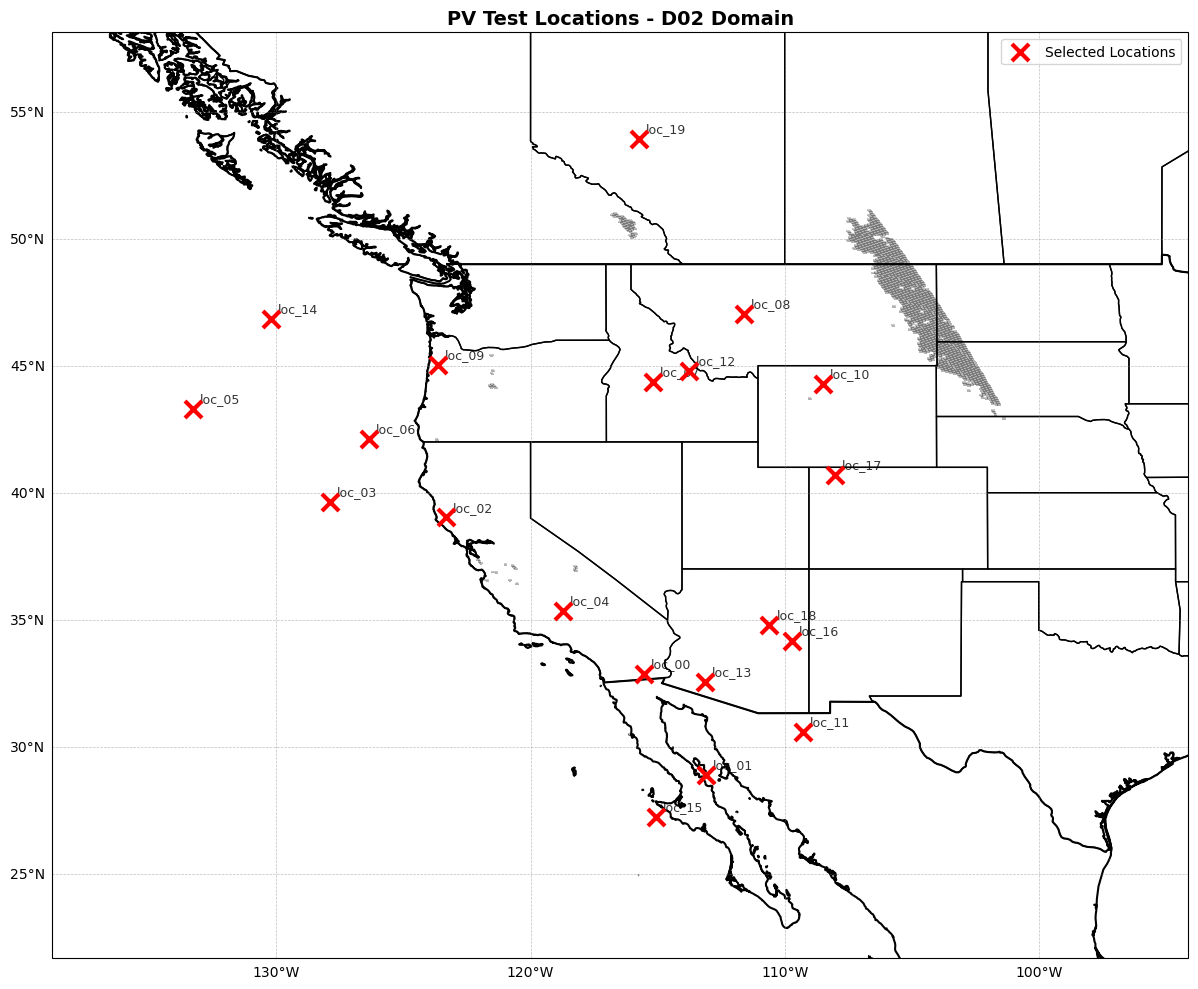

In [12]:
# Visualize test locations on the domain
fig, ax = plot_locations_on_map(test_locations, sample_mask, 
                                 title=f"{resource.upper()} Test Locations - {domain.upper()} Domain")
plt.show()

### Analyze GWL 0.8°C - All Simulations

Extract time series and calculate correlations for each simulation at the 0.8°C warming level.

In [13]:
# Store results for each simulation at GWL 0.8
gwl_08_results = {}

for sim in simulations:
    print(f"\n{'='*60}")
    print(f"Processing {sim} at GWL 0.8°C")
    print(f"{'='*60}")
    
    # Select drought mask for this simulation and GWL
    mask = all_drought_mask.sel(simulation=sim, target_gwl=0.8)
    
    # Extract time series at test locations
    print("Extracting time series at test locations...")
    ts_df = extract_location_time_series(mask, test_locations)
    
    print(f"Time series shape: {ts_df.shape}")
    print(f"Date range: {ts_df.index[0]} to {ts_df.index[-1]}")
    print(f"Mean drought frequency across locations: {ts_df.mean().mean():.3f}")
    
    # Calculate spatial association metrics
    print("Calculating spatial correlations and similarity metrics...")
    results = calculate_spatial_correlations(ts_df)
    
    pearson_matrix = results['pearson']
    co_occur_matrix = results['co_occurrence']
    jaccard_matrix = results['jaccard']
    corr_info = results['info']
    
    print(f"Locations: {corr_info['n_valid']} valid, {corr_info['n_filtered']} filtered (zero variance)")
    
    # Calculate mean metrics (upper triangle only, excluding diagonal)
    mask_upper = np.triu_indices_from(pearson_matrix.values, k=1)
    mean_pearson = pearson_matrix.values[mask_upper].mean()
    mean_co_occur = np.nanmean(co_occur_matrix.values[mask_upper])  # Use nanmean for co-occurrence
    mean_jaccard = jaccard_matrix.values[mask_upper].mean()
    
    # Store results
    gwl_08_results[sim] = {
        'time_series': ts_df,
        'pearson': pearson_matrix,
        'co_occurrence': co_occur_matrix,
        'jaccard': jaccard_matrix,
        'corr_info': corr_info,
        'mean_pearson': mean_pearson,
        'mean_co_occur': mean_co_occur,
        'mean_jaccard': mean_jaccard
    }
    
    print(f"Mean Pearson correlation: {mean_pearson:.3f}")
    print(f"Mean co-occurrence probability: {mean_co_occur:.3f}")
    print(f"Mean Jaccard similarity: {mean_jaccard:.3f}")

print("\n" + "="*60)
print("Summary of spatial association metrics at GWL 0.8°C:")
print(f"{'Simulation':<20s} {'Pearson':>10s} {'Co-occur':>10s} {'Jaccard':>10s} {'N Locs':>8s}")
print("-" * 60)
for sim in simulations:
    n_valid = gwl_08_results[sim]['corr_info']['n_valid']
    pearson = gwl_08_results[sim]['mean_pearson']
    co_occur = gwl_08_results[sim]['mean_co_occur']
    jaccard = gwl_08_results[sim]['mean_jaccard']
    print(f"{sim:<20s} {pearson:>10.3f} {co_occur:>10.3f} {jaccard:>10.3f} {n_valid:>8d}")



Processing mpi-esm1-2-hr at GWL 0.8°C
Extracting time series at test locations...
Time series shape: (29930, 20)
Date range: 1981-01-01 00:00:00 to 2062-12-31 00:00:00
Mean drought frequency across locations: 0.036
Calculating spatial correlations and similarity metrics...
Locations: 8 valid, 12 filtered (zero variance)
Mean Pearson correlation: 0.067
Mean co-occurrence probability: 1.656
Mean Jaccard similarity: 0.088

Processing miroc6 at GWL 0.8°C
Extracting time series at test locations...
Time series shape: (29930, 20)
Date range: 1981-01-01 00:00:00 to 2062-12-31 00:00:00
Mean drought frequency across locations: 0.035
Calculating spatial correlations and similarity metrics...
Locations: 8 valid, 12 filtered (zero variance)
Mean Pearson correlation: 0.077
Mean co-occurrence probability: 1.786
Mean Jaccard similarity: 0.092

Processing taiesm1 at GWL 0.8°C
Extracting time series at test locations...
Time series shape: (29930, 20)
Date range: 1981-01-01 00:00:00 to 2062-12-31 00:00

In [14]:
# Debug: Check for issues with the correlation calculation
sim_test = 'mpi-esm1-2-hr'
mask_test = all_drought_mask.sel(simulation=sim_test, target_gwl=0.8)
ts_test = extract_location_time_series(mask_test, test_locations)

print("Checking for potential issues:")
print(f"\nTime series info:")
print(f"  Shape: {ts_test.shape}")
print(f"  Data type: {ts_test.dtypes.unique()}")
print(f"  Contains NaN: {ts_test.isna().any().any()}")
print(f"  All NaN columns: {ts_test.columns[ts_test.isna().all()].tolist()}")

print(f"\nDrought statistics per location:")
for col in ts_test.columns[:]:  # First 5 locations
    vals = ts_test[col].dropna()
    print(f"  {col}: mean={vals.mean():.4f}, std={vals.std():.4f}, unique_values={vals.nunique()}")

print(f"\nCorrelation matrix sample (first 5x5):")
corr_test = ts_test.corr()
print(corr_test.iloc[:, :])

Checking for potential issues:

Time series info:
  Shape: (29930, 20)
  Data type: [dtype('float64')]
  Contains NaN: True
  All NaN columns: []

Drought statistics per location:
  loc_00: mean=0.0915, std=0.2883, unique_values=2
  loc_01: mean=0.0000, std=0.0000, unique_values=1
  loc_02: mean=0.0841, std=0.2776, unique_values=2
  loc_03: mean=0.0000, std=0.0000, unique_values=1
  loc_04: mean=0.0000, std=0.0000, unique_values=1
  loc_05: mean=0.0000, std=0.0000, unique_values=1
  loc_06: mean=0.0000, std=0.0000, unique_values=1
  loc_07: mean=0.0000, std=0.0000, unique_values=1
  loc_08: mean=0.0000, std=0.0000, unique_values=1
  loc_09: mean=0.0882, std=0.2836, unique_values=2
  loc_10: mean=0.0000, std=0.0000, unique_values=1
  loc_11: mean=0.0000, std=0.0000, unique_values=1
  loc_12: mean=0.0000, std=0.0000, unique_values=1
  loc_13: mean=0.0919, std=0.2889, unique_values=2
  loc_14: mean=0.0000, std=0.0000, unique_values=1
  loc_15: mean=0.0000, std=0.0000, unique_values=1
  lo

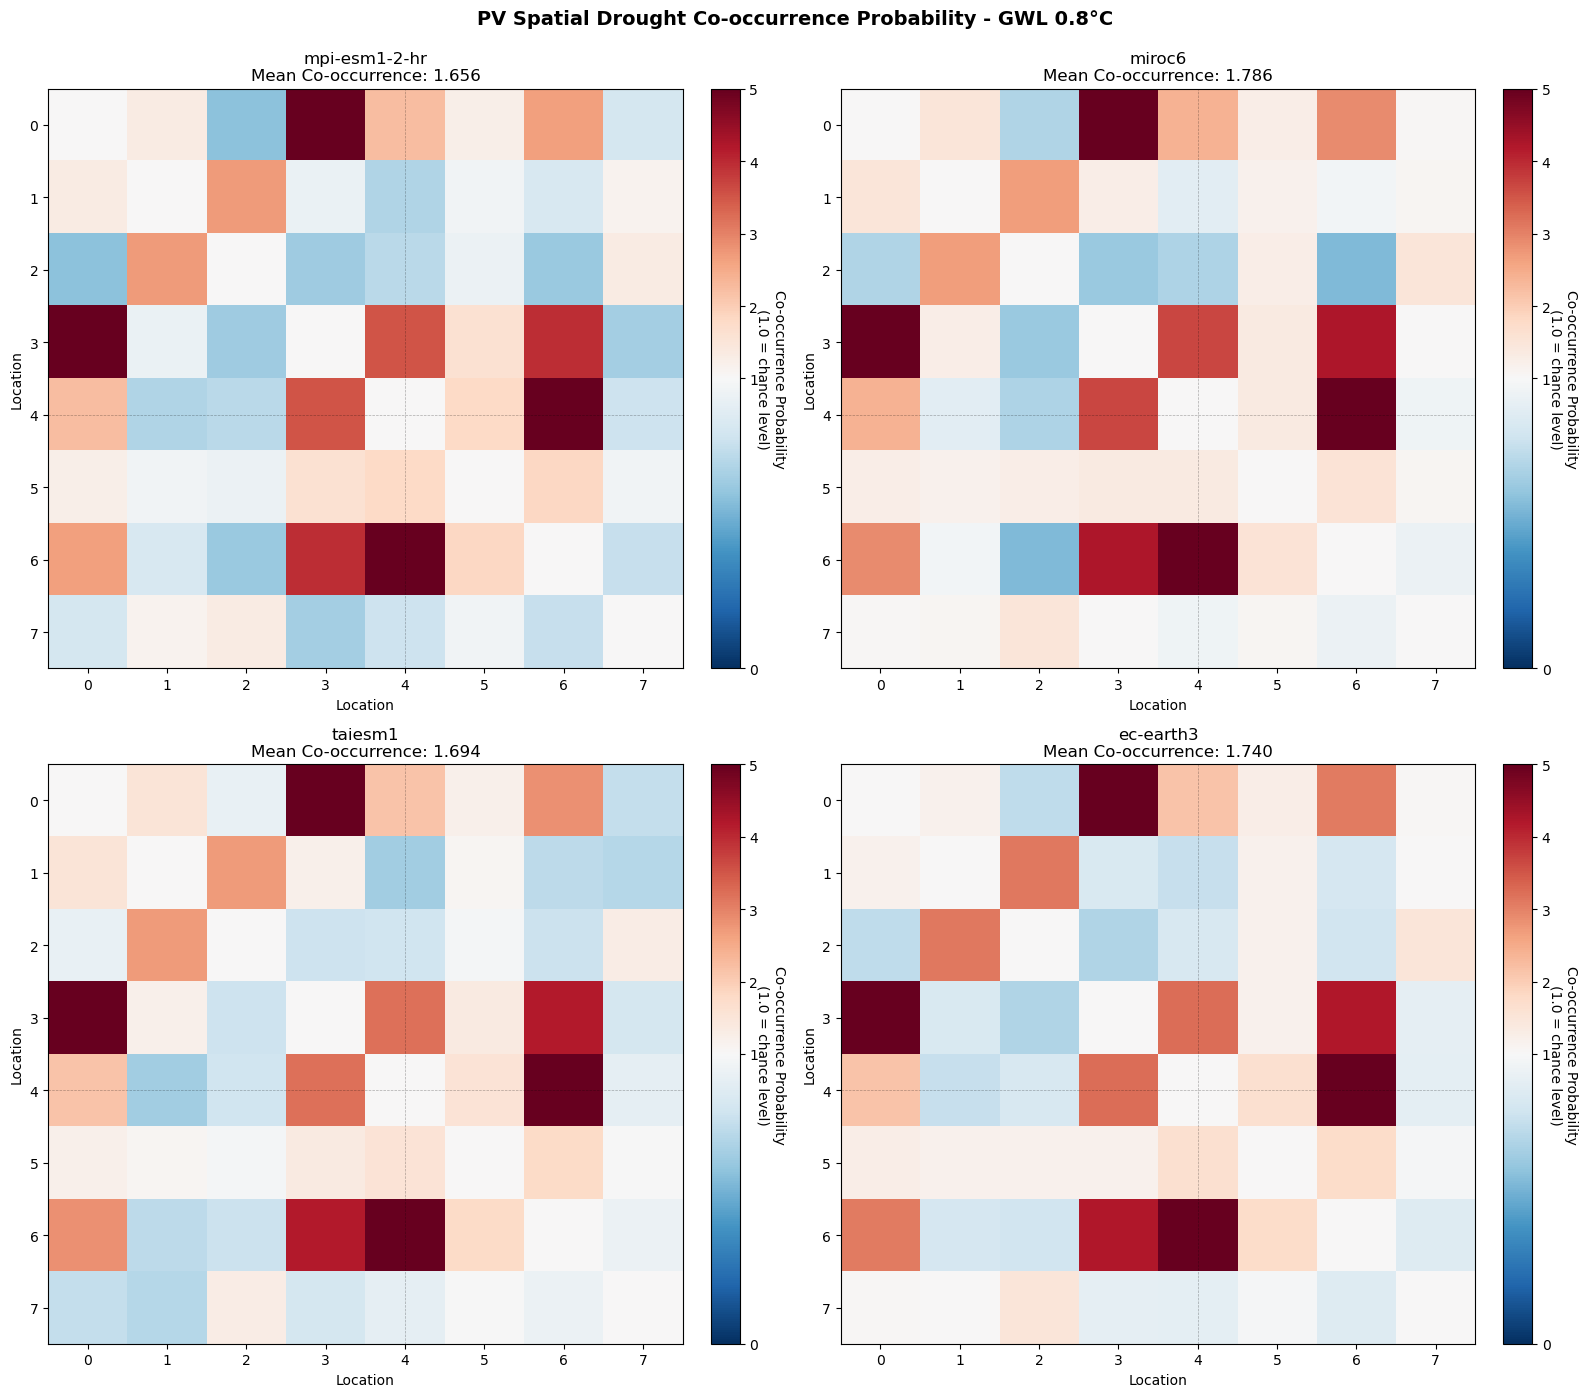

In [15]:
# Visualize co-occurrence probability matrices for all simulations at GWL 0.8
from matplotlib.colors import TwoSlopeNorm

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

# Customizable colorbar range with white at 1.0 (chance level)
vmin_cooccur = 0
vmax_cooccur = 5  # Adjust this to change upper limit

for i, sim in enumerate(simulations):
    co_occur = gwl_08_results[sim]['co_occurrence']
    mean_co_occur = gwl_08_results[sim]['mean_co_occur']
    
    # Create heatmap with colormap centered at 1.0 (chance level)
    # Use TwoSlopeNorm to ensure white appears exactly at 1.0
    # Blue = below chance, White = chance level, Red = above chance
    norm = TwoSlopeNorm(vmin=vmin_cooccur, vcenter=1.0, vmax=vmax_cooccur)
    im = axes[i].imshow(co_occur, cmap='RdBu_r', norm=norm, aspect='auto')
    
    # Set title with mean co-occurrence
    axes[i].set_title(f'{sim}\nMean Co-occurrence: {mean_co_occur:.3f}', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    cbar.set_label('Co-occurrence Probability\n(1.0 = chance level)', rotation=270, labelpad=20)
    
    # Add horizontal line at chance level
    axes[i].axhline(y=len(co_occur)/2, color='black', linestyle='--', alpha=0.3, linewidth=0.5)
    axes[i].axvline(x=len(co_occur)/2, color='black', linestyle='--', alpha=0.3, linewidth=0.5)
    
    axes[i].set_xlabel('Location')
    axes[i].set_ylabel('Location')

plt.suptitle(f'{resource.upper()} Spatial Drought Co-occurrence Probability - GWL 0.8°C', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


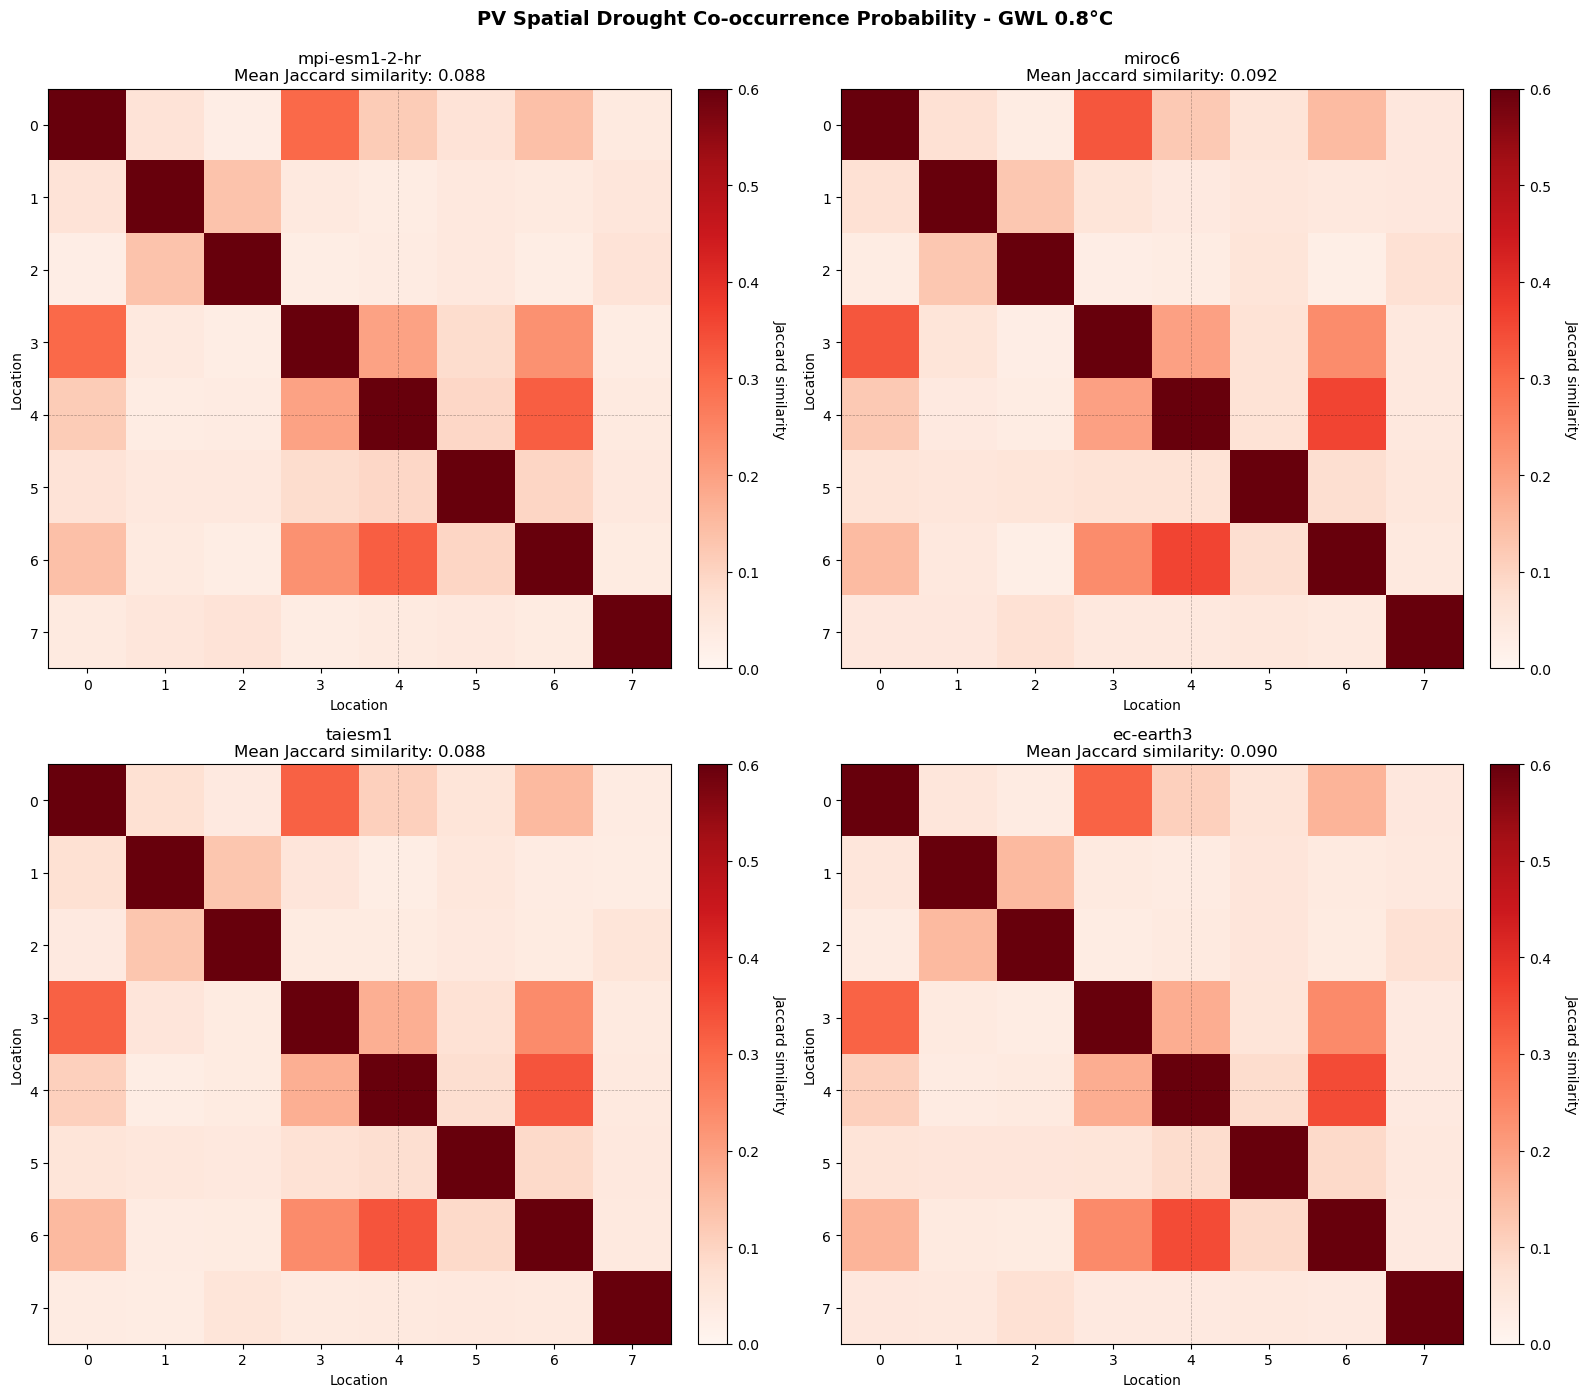

In [16]:
# Visualize co-occurrence probability matrices for all simulations at GWL 0.8
from matplotlib.colors import TwoSlopeNorm

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

# Customizable colorbar range with white at 1.0 (chance level)
vmin_cooccur = 0
vmax_cooccur = 5  # Adjust this to change upper limit

for i, sim in enumerate(simulations):
    co_occur = gwl_08_results[sim]['jaccard']
    mean_co_occur = gwl_08_results[sim]['mean_jaccard']
    
    # Create heatmap with colormap centered at 1.0 (chance level)
    # Use TwoSlopeNorm to ensure white appears exactly at 1.0
    # Blue = below chance, White = chance level, Red = above chance
    norm = TwoSlopeNorm(vmin=vmin_cooccur, vcenter=1.0, vmax=vmax_cooccur)
    im = axes[i].imshow(co_occur, cmap='Reds',vmin=0,vmax=0.6, aspect='auto')
    
    # Set title with mean co-occurrence
    axes[i].set_title(f'{sim}\nMean Jaccard similarity: {mean_co_occur:.3f}', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    cbar.set_label('Jaccard similarity', rotation=270, labelpad=20)
    
    # Add horizontal line at chance level
    axes[i].axhline(y=len(co_occur)/2, color='black', linestyle='--', alpha=0.3, linewidth=0.5)
    axes[i].axvline(x=len(co_occur)/2, color='black', linestyle='--', alpha=0.3, linewidth=0.5)
    
    axes[i].set_xlabel('Location')
    axes[i].set_ylabel('Location')

plt.suptitle(f'{resource.upper()} Spatial Drought Co-occurrence Probability - GWL 0.8°C', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


### Analyze GWL 2.0°C - All Simulations

Repeat the same analysis for the 2.0°C warming level to compare how spatial correlation patterns change.

In [17]:
# Store results for each simulation at GWL 2.0
gwl_20_results = {}

for sim in simulations:
    print(f"\n{'='*60}")
    print(f"Processing {sim} at GWL 2.0°C")
    print(f"{'='*60}")
    
    # Select drought mask for this simulation and GWL
    mask = all_drought_mask.sel(simulation=sim, target_gwl=2.0)
    
    # Extract time series at test locations (same locations as GWL 0.8)
    print("Extracting time series at test locations...")
    ts_df = extract_location_time_series(mask, test_locations)
    
    print(f"Time series shape: {ts_df.shape}")
    print(f"Date range: {ts_df.index[0]} to {ts_df.index[-1]}")
    print(f"Mean drought frequency across locations: {ts_df.mean().mean():.3f}")
    
    # Calculate spatial association metrics
    print("Calculating spatial correlations and similarity metrics...")
    results = calculate_spatial_correlations(ts_df)
    
    pearson_matrix = results['pearson']
    co_occur_matrix = results['co_occurrence']
    jaccard_matrix = results['jaccard']
    corr_info = results['info']
    
    print(f"Locations: {corr_info['n_valid']} valid, {corr_info['n_filtered']} filtered (zero variance)")
    
    # Calculate mean metrics (upper triangle only, excluding diagonal)
    mask_upper = np.triu_indices_from(pearson_matrix.values, k=1)
    mean_pearson = pearson_matrix.values[mask_upper].mean()
    mean_co_occur = np.nanmean(co_occur_matrix.values[mask_upper])
    mean_jaccard = jaccard_matrix.values[mask_upper].mean()
    
    # Store results
    gwl_20_results[sim] = {
        'time_series': ts_df,
        'pearson': pearson_matrix,
        'co_occurrence': co_occur_matrix,
        'jaccard': jaccard_matrix,
        'corr_info': corr_info,
        'mean_pearson': mean_pearson,
        'mean_co_occur': mean_co_occur,
        'mean_jaccard': mean_jaccard
    }
    
    print(f"Mean Pearson correlation: {mean_pearson:.3f}")
    print(f"Mean co-occurrence probability: {mean_co_occur:.3f}")
    print(f"Mean Jaccard similarity: {mean_jaccard:.3f}")

print("\n" + "="*60)
print("Summary of spatial association metrics at GWL 2.0°C:")
print(f"{'Simulation':<20s} {'Pearson':>10s} {'Co-occur':>10s} {'Jaccard':>10s} {'N Locs':>8s}")
print("-" * 60)
for sim in simulations:
    n_valid = gwl_20_results[sim]['corr_info']['n_valid']
    pearson = gwl_20_results[sim]['mean_pearson']
    co_occur = gwl_20_results[sim]['mean_co_occur']
    jaccard = gwl_20_results[sim]['mean_jaccard']
    print(f"{sim:<20s} {pearson:>10.3f} {co_occur:>10.3f} {jaccard:>10.3f} {n_valid:>8d}")


Processing mpi-esm1-2-hr at GWL 2.0°C
Extracting time series at test locations...
Time series shape: (29930, 20)
Date range: 1981-01-01 00:00:00 to 2062-12-31 00:00:00
Mean drought frequency across locations: 0.038
Calculating spatial correlations and similarity metrics...
Locations: 8 valid, 12 filtered (zero variance)
Mean Pearson correlation: 0.076
Mean co-occurrence probability: 1.707
Mean Jaccard similarity: 0.095

Processing miroc6 at GWL 2.0°C
Extracting time series at test locations...
Time series shape: (29930, 20)
Date range: 1981-01-01 00:00:00 to 2062-12-31 00:00:00
Mean drought frequency across locations: 0.036
Calculating spatial correlations and similarity metrics...
Locations: 8 valid, 12 filtered (zero variance)
Mean Pearson correlation: 0.082
Mean co-occurrence probability: 1.803
Mean Jaccard similarity: 0.095

Processing taiesm1 at GWL 2.0°C
Extracting time series at test locations...
Time series shape: (29930, 20)
Date range: 1981-01-01 00:00:00 to 2062-12-31 00:00

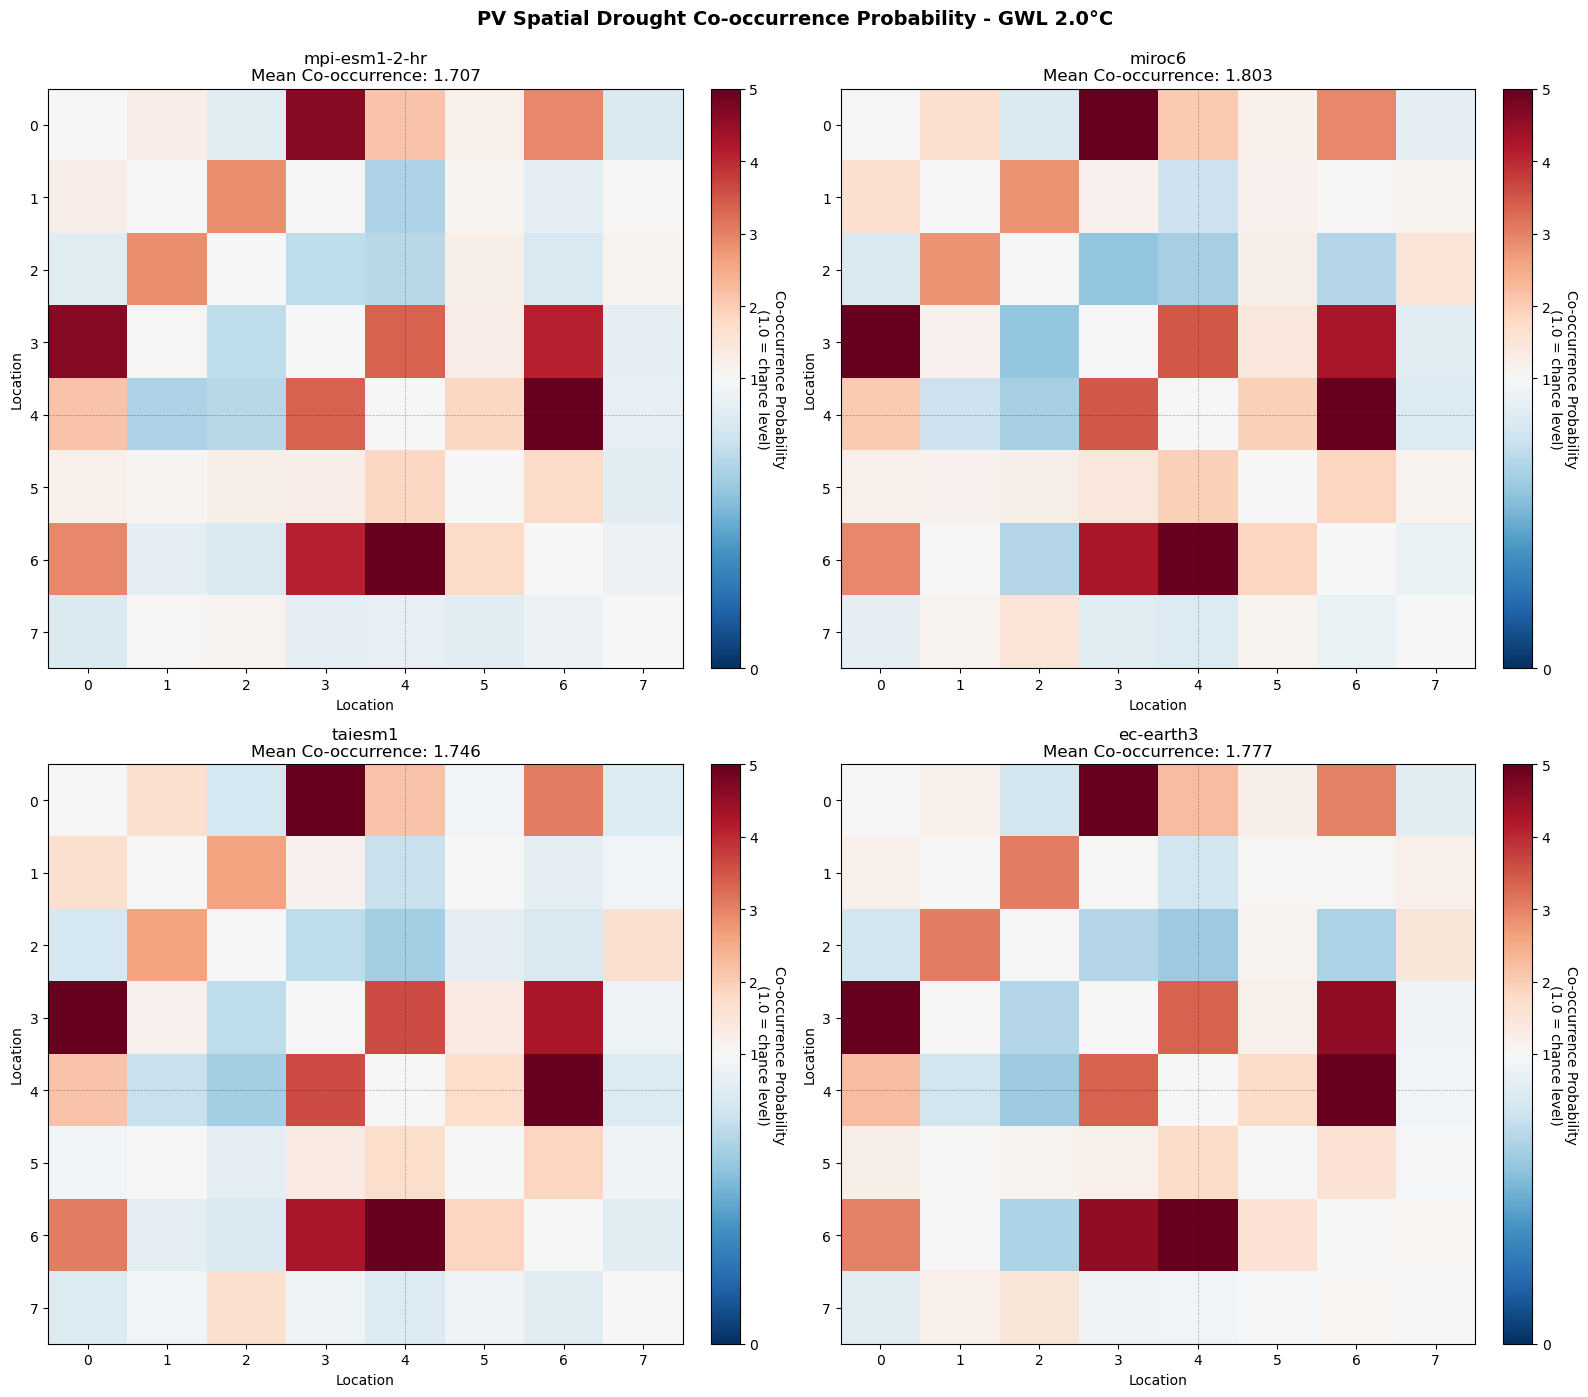

In [18]:
# Visualize co-occurrence probability matrices for all simulations at GWL 2.0
from matplotlib.colors import TwoSlopeNorm

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

# Customizable colorbar range with white at 1.0 (chance level)
vmin_cooccur = 0
vmax_cooccur = 5  # Adjust this to change upper limit

for i, sim in enumerate(simulations):
    co_occur = gwl_20_results[sim]['co_occurrence']
    mean_co_occur = gwl_20_results[sim]['mean_co_occur']
    
    # Create heatmap with colormap centered at 1.0 (chance level)
    # Use TwoSlopeNorm to ensure white appears exactly at 1.0
    # Blue = below chance, White = chance level, Red = above chance
    norm = TwoSlopeNorm(vmin=vmin_cooccur, vcenter=1.0, vmax=vmax_cooccur)
    im = axes[i].imshow(co_occur, cmap='RdBu_r', norm=norm, aspect='auto')
    
    # Set title with mean co-occurrence
    axes[i].set_title(f'{sim}\nMean Co-occurrence: {mean_co_occur:.3f}', fontsize=12)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    cbar.set_label('Co-occurrence Probability\n(1.0 = chance level)', rotation=270, labelpad=20)
    
    # Add horizontal line at chance level
    axes[i].axhline(y=len(co_occur)/2, color='black', linestyle='--', alpha=0.3, linewidth=0.5)
    axes[i].axvline(x=len(co_occur)/2, color='black', linestyle='--', alpha=0.3, linewidth=0.5)
    
    axes[i].set_xlabel('Location')
    axes[i].set_ylabel('Location')

plt.suptitle(f'{resource.upper()} Spatial Drought Co-occurrence Probability - GWL 2.0°C', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


### Compare GWL 0.8°C vs 2.0°C

Analyze how spatial correlation patterns change between warming levels.

Spatial Association Metrics Comparison Across Warming Levels:

Pearson Correlation:
   Simulation  Pearson 0.8°C  Pearson 2.0°C  Pearson Δ
mpi-esm1-2-hr       0.067382       0.076130   0.008748
       miroc6       0.077415       0.081528   0.004114
      taiesm1       0.069867       0.075042   0.005175
    ec-earth3       0.073818       0.072148  -0.001670

Co-occurrence Probability:
   Simulation  Co-occur 0.8°C  Co-occur 2.0°C  Co-occur Δ
mpi-esm1-2-hr        1.655652        1.706553    0.050900
       miroc6        1.786290        1.803494    0.017205
      taiesm1        1.694482        1.745997    0.051515
    ec-earth3        1.740157        1.777025    0.036868

Jaccard Similarity:
   Simulation  Jaccard 0.8°C  Jaccard 2.0°C  Jaccard Δ
mpi-esm1-2-hr       0.087517       0.094650   0.007133
       miroc6       0.092064       0.095148   0.003083
      taiesm1       0.087803       0.091353   0.003550
    ec-earth3       0.090232       0.086810  -0.003422


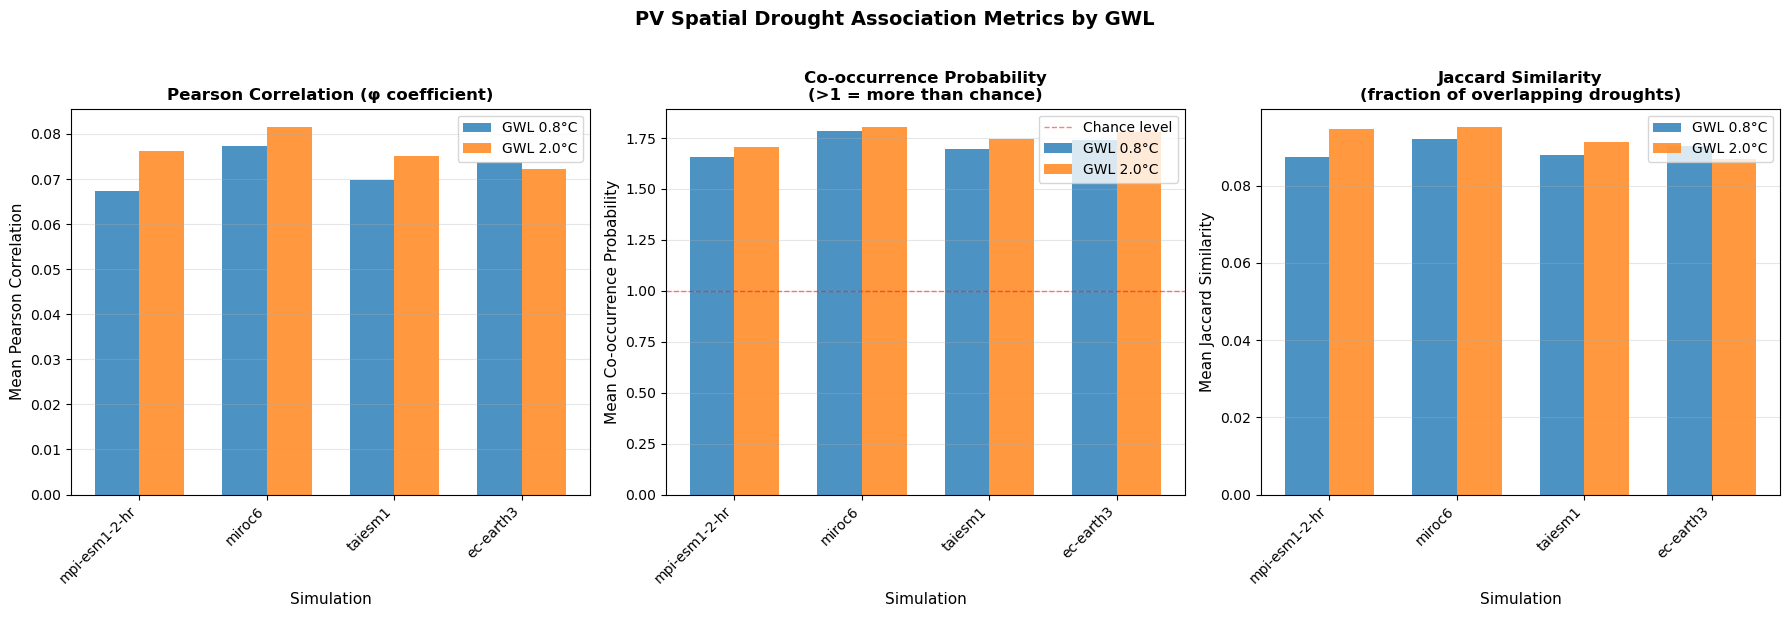

In [19]:
# Compare metrics across GWLs for all three association measures
comparison_data = []
for sim in simulations:
    comparison_data.append({
        'Simulation': sim,
        'Pearson 0.8°C': gwl_08_results[sim]['mean_pearson'],
        'Pearson 2.0°C': gwl_20_results[sim]['mean_pearson'],
        'Pearson Δ': gwl_20_results[sim]['mean_pearson'] - gwl_08_results[sim]['mean_pearson'],
        'Co-occur 0.8°C': gwl_08_results[sim]['mean_co_occur'],
        'Co-occur 2.0°C': gwl_20_results[sim]['mean_co_occur'],
        'Co-occur Δ': gwl_20_results[sim]['mean_co_occur'] - gwl_08_results[sim]['mean_co_occur'],
        'Jaccard 0.8°C': gwl_08_results[sim]['mean_jaccard'],
        'Jaccard 2.0°C': gwl_20_results[sim]['mean_jaccard'],
        'Jaccard Δ': gwl_20_results[sim]['mean_jaccard'] - gwl_08_results[sim]['mean_jaccard']
    })

comparison_df = pd.DataFrame(comparison_data)
print("Spatial Association Metrics Comparison Across Warming Levels:")
print("\nPearson Correlation:")
print(comparison_df[['Simulation', 'Pearson 0.8°C', 'Pearson 2.0°C', 'Pearson Δ']].to_string(index=False))
print("\nCo-occurrence Probability:")
print(comparison_df[['Simulation', 'Co-occur 0.8°C', 'Co-occur 2.0°C', 'Co-occur Δ']].to_string(index=False))
print("\nJaccard Similarity:")
print(comparison_df[['Simulation', 'Jaccard 0.8°C', 'Jaccard 2.0°C', 'Jaccard Δ']].to_string(index=False))

# Visualize comparison for all three metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

x = np.arange(len(simulations))
width = 0.35

# Pearson correlation
axes[0].bar(x - width/2, comparison_df['Pearson 0.8°C'], width, label='GWL 0.8°C', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Pearson 2.0°C'], width, label='GWL 2.0°C', alpha=0.8)
axes[0].set_xlabel('Simulation', fontsize=11)
axes[0].set_ylabel('Mean Pearson Correlation', fontsize=11)
axes[0].set_title('Pearson Correlation (φ coefficient)', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(simulations, rotation=45, ha='right')
axes[0].axhline(y=0, color='k', linewidth=0.5)
axes[0].grid(axis='y', alpha=0.3)
axes[0].legend()

# Co-occurrence probability
axes[1].bar(x - width/2, comparison_df['Co-occur 0.8°C'], width, label='GWL 0.8°C', alpha=0.8)
axes[1].bar(x + width/2, comparison_df['Co-occur 2.0°C'], width, label='GWL 2.0°C', alpha=0.8)
axes[1].set_xlabel('Simulation', fontsize=11)
axes[1].set_ylabel('Mean Co-occurrence Probability', fontsize=11)
axes[1].set_title('Co-occurrence Probability\n(>1 = more than chance)', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(simulations, rotation=45, ha='right')
axes[1].axhline(y=1.0, color='r', linewidth=1, linestyle='--', alpha=0.5, label='Chance level')
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend()

# Jaccard similarity
axes[2].bar(x - width/2, comparison_df['Jaccard 0.8°C'], width, label='GWL 0.8°C', alpha=0.8)
axes[2].bar(x + width/2, comparison_df['Jaccard 2.0°C'], width, label='GWL 2.0°C', alpha=0.8)
axes[2].set_xlabel('Simulation', fontsize=11)
axes[2].set_ylabel('Mean Jaccard Similarity', fontsize=11)
axes[2].set_title('Jaccard Similarity\n(fraction of overlapping droughts)', fontsize=12, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(simulations, rotation=45, ha='right')
axes[2].axhline(y=0, color='k', linewidth=0.5)
axes[2].grid(axis='y', alpha=0.3)
axes[2].legend()

plt.suptitle(f'{resource.upper()} Spatial Drought Association Metrics by GWL', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Next Steps

1. **Replace test locations with actual facility locations:**
   - Implement `load_facility_locations()` function
   - Convert facility lat/lon to grid indices
   - Re-run analysis with real facilities

2. **Extend analysis to windpower:**
   - Change `resource = 'windpower'` and `module = 'onshore'/'offshore'`
   - Compare PV vs windpower spatial correlation patterns

3. **Cross-resource correlation:**
   - Correlate PV drought with windpower drought at the same locations
   - Identify regions where droughts occur simultaneously for both resources

4. **Identify correlation clusters:**
   - Use hierarchical clustering on correlation matrices
   - Map spatial regions with similar drought patterns
   - Quantify geographic scales of correlation (distance decay)

5. **Statistical significance:**
   - Test if correlations are significant vs. random
   - Account for temporal autocorrelation in drought time series

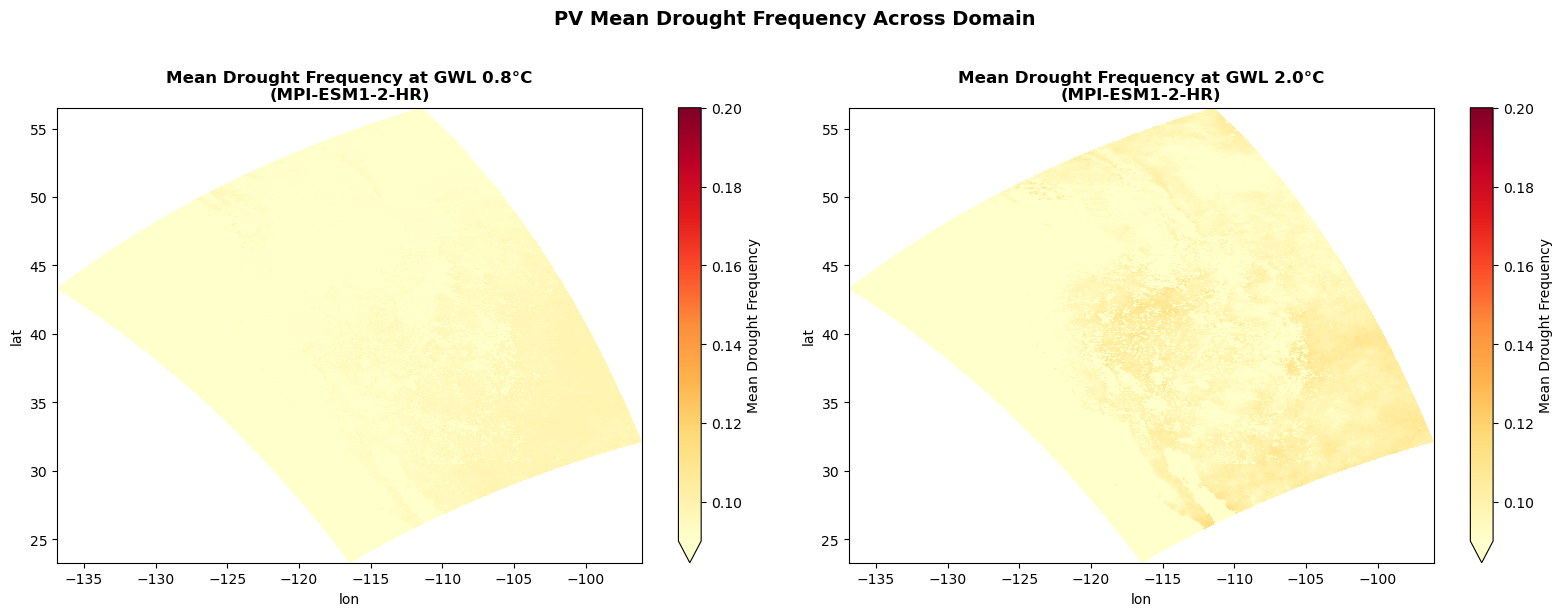

In [20]:
# quick side exlporation: using the original drought masks, make a plot of what fraction of the time each location is in drought, for both GWLs

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, gwl in enumerate([0.8, 2.0]):
    drought_mask = all_drought_mask.sel(target_gwl=gwl)
    mean_drought_freq = drought_mask.mean(dim='time')
    
    im = mean_drought_freq.sel(simulation='mpi-esm1-2-hr').plot(
        ax=axes[i],
        x='lon',
        y='lat',
        cmap='YlOrRd',
        vmin=0.09,
        vmax=.2,
        add_colorbar=True,
        cbar_kwargs={'label': 'Mean Drought Frequency'}
    )
    
    axes[i].set_title(f'Mean Drought Frequency at GWL {gwl}°C\n(MPI-ESM1-2-HR)', fontsize=12, fontweight='bold')
plt.suptitle(f'{resource.upper()} Mean Drought Frequency Across Domain', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

